In [1]:
input_dir = "/home/julisn/Hamburg/Zwischenergebnisse/cuprates/data"
in_cfg = "config_b20_mu0.5.toml"
cfg = joinpath(input_dir, in_cfg)


cfg_file = "G:/Hamburg/b20.0_mu1.0/lDGAConfig.toml"
using Plots, LaTeXStrings
using Plots.PlotMeasures
using LaTeXStrings
empty!(ARGS)
push!(ARGS, cfg_file)
#push!(ARGS, "/home/julisn/Hamburg/ED_data/cuprate_test/b20.0_mu1.0/lDGAConfig.toml")# "G:/tmp_ED_data/U2.0_b20.0_mu1.0.toml")
include(joinpath(@__DIR__,"../examples/example00_lDGA.jl"));

plot_dir = "G:/Hamburg/ThermodynamicsPlots"# "/home/julisn/Hamburg/Zwischenergebnisse/plots_thesis/numerics/thermodyn_tests/"

  Activating project at `G:\Codes\LadderDGA.jl`


[ Info: Reading Inputs...
[ Info: Setting up calculation for kGrid 2Dsc-0.25-0.05-0.025 of size 10


DBG: NOT using diagonal terms in λ₀


┌ Info: Inputs Read. Starting Computation.
│     Local susceptibilities with ranges are:
│     χLoc_m(1:301) = 0.4356, χLoc_d(1:301) = 0.0644
│     sum χupup check (plain ?≈? tail sub ?≈? imp_dens ?≈? n/2 (1-n/2)): 0.24860048983264754 ?=? 0.2500077791504396 ?≈? 0.25000777915043954 ≟ 0.24999903238559407"
│ Local EoM check for the first 5 frequencies: 0.0001, 0.0002, 0.0002, 0.0003, 0.0003  
└     
[ Info: m channel: |∑χ(q=0,ω≠0)| = 0.000297843848 ≟ 0
[ Info: d channel: |∑χ(q=0,ω≠0)| = 0.000209554839 ≟ 0


DBG: NOT using diagonal terms in λ₀


LoadError: ParseError:
[90m# Error @ [0;0m]8;;file://G:/Codes/LadderDGA.jl/notebooks/In[1]#15:15\[90mIn[1]:15:15[0;0m]8;;\

plot_dir = "G:[48;2;120;70;70m\H[0;0mamburg\ThermodynamicsPlots"# "/home/julisn/Hamburg/Zwischenergebnisse/plots_thesis/numerics/thermodyn_tests/"
[90m#             └┘ ── [0;0m[91minvalid escape sequence[0;0m

# Setup and read DMFT quantities

In [18]:
λd_test = 5.5
rhs_d0,PP_p1 = LadderDGA.LambdaCorrection.λm_rhs(χm, χd, lDGAhelper)
λm_d0  = LadderDGA.LambdaCorrection.λm_correction_val(χm, rhs_d0, lDGAhelper)
rhs,PP_p1 = LadderDGA.LambdaCorrection.λm_rhs(χm, χd, lDGAhelper, λd=λd_test)
λm  = LadderDGA.LambdaCorrection.λm_correction_val(χm, rhs, lDGAhelper)

0.10717832792085231

# Investigate tail behavior

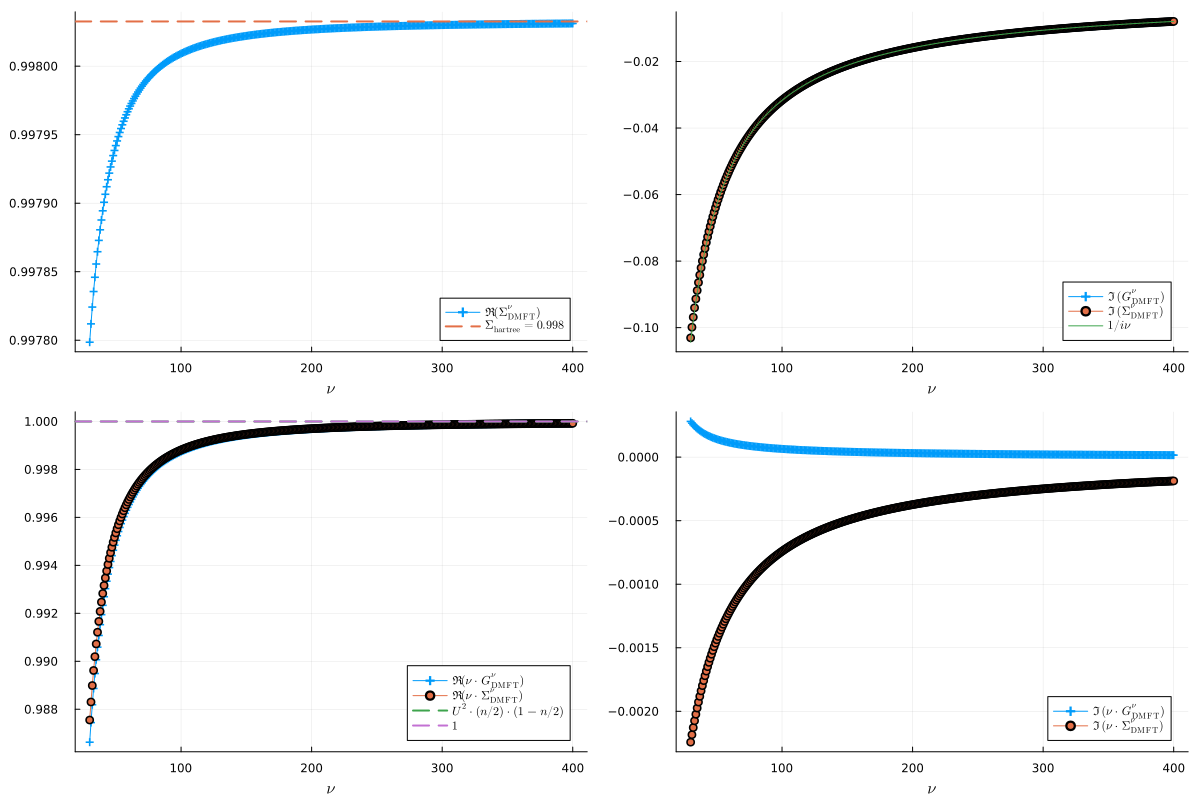

In [22]:
U = lDGAhelper.mP.U
n = lDGAhelper.mP.n
Σ_hartree = LadderDGA.Σ_hartree(lDGAhelper.mP)
νGrid_loc = 30:400
iνGrid_loc = LadderDGA.iν_array(lDGAhelper.mP.β, νGrid_loc)
Σ_c0 = U * (n/2) 
Σ_c1 = U^2 * (n/2)* (1-n/2)

G_loc = lDGAhelper.gImp[1,νGrid_loc]
Σ_loc = lDGAhelper.Σ_loc[νGrid_loc]
G_ν_loc = iνGrid_loc .* G_loc
Σ_ν_loc = iνGrid_loc .* (Σ_loc .- Σ_c0)


p1 = plot(νGrid_loc, real(Σ_loc), markershape=:auto, label=L"\Re (Σ^\nu_\mathrm{DMFT})", xlabel=L"\nu")
hline!(p1, νGrid_loc, [Σ_c0], lw=2, ls=:dash, label=L"\Sigma_\mathrm{hartree}=%$(round(Σ_hartree,digits=4))")
p2 = plot(νGrid_loc, imag(G_loc), markershape=:auto, label=L"\Im (G^\nu_\mathrm{DMFT})", xlabel=L"\nu")
plot!(νGrid_loc, imag(Σ_loc), markershape=:auto, label=L"\Im (\Sigma^\nu_\mathrm{DMFT})", xlabel=L"\nu")
plot!(p2, νGrid_loc, imag(1 ./ iνGrid_loc), label=L"1/i\nu")
p3 = plot(νGrid_loc, real(G_ν_loc), markershape=:auto, label=L"\Re ( \nu \cdot G^\nu_\mathrm{DMFT})", xlabel=L"\nu")
plot!(p3, νGrid_loc, real(Σ_ν_loc), markershape=:auto, label=L"\Re ( \nu \cdot \Sigma^\nu_\mathrm{DMFT})", xlabel=L"\nu")
hline!(p3, [Σ_c1],lw=2, ls=:dash, label=L"U^2 \cdot (n/2) \cdot (1 - n/2)")
hline!(p3, [1.0],lw=2, ls=:dash, label=L"1")
p4 = plot(νGrid_loc, imag(G_ν_loc), markershape=:auto, label=L"\Im ( \nu \cdot G^\nu_\mathrm{DMFT})", xlabel=L"\nu")
plot!(p4, νGrid_loc, imag(Σ_ν_loc), markershape=:auto, label=L"\Im ( \nu \cdot \Sigma^\nu_\mathrm{DMFT})", xlabel=L"\nu")
plot(p1, p2, p3, p4, size=(1200,800))

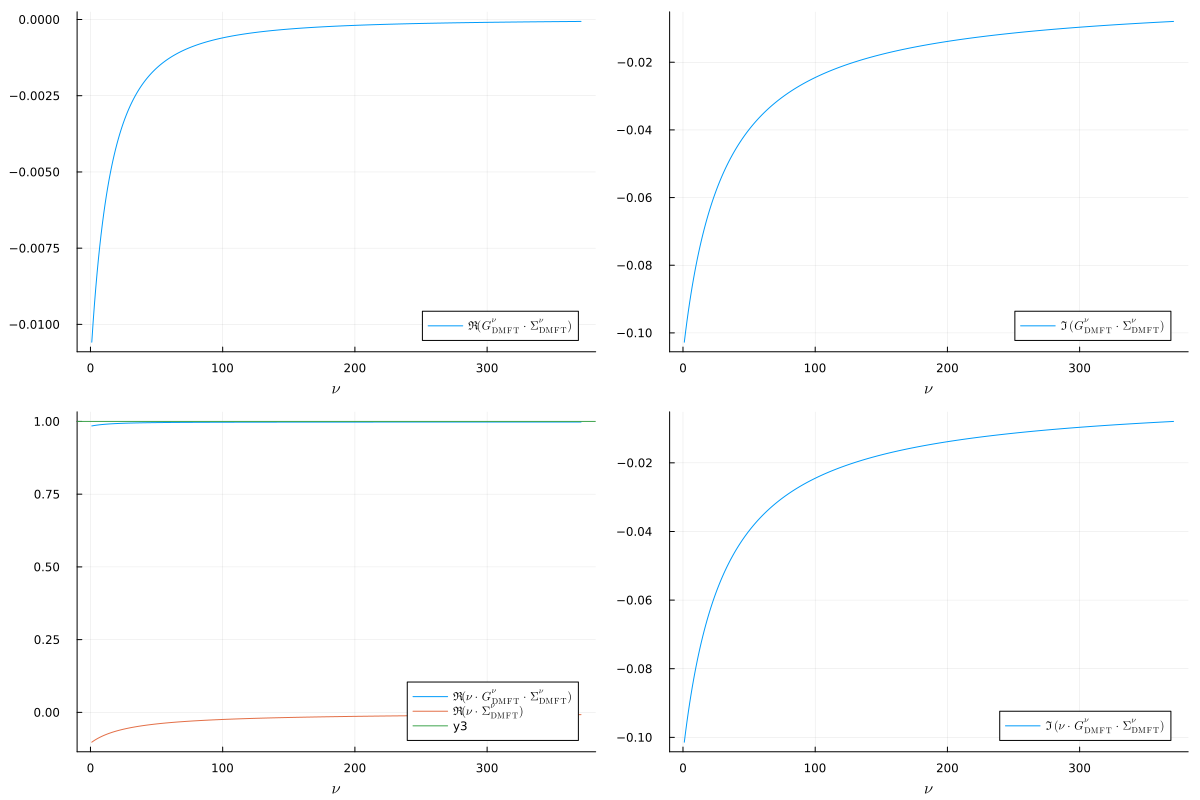

In [25]:
GΣ_loc = lDGAhelper.gImp[1,νGrid_loc] .* lDGAhelper.Σ_loc[νGrid_loc]
GΣ_ν_loc = iνGrid_loc .* GΣ_loc
Σ_ν_loc = lDGAhelper.Σ_loc[νGrid_loc] .* imag(GΣ_loc)
nden = lDGAhelper.mP.n
Σlim = U^2 * (nden/2) * (1 - nden/2)

p1 = plot(real(GΣ_loc), label=L"\Re (G^\nu_\mathrm{DMFT} \cdot \Sigma^\nu_\mathrm{DMFT})", xlabel=L"\nu")
p2 = plot(imag(GΣ_loc), label=L"\Im (G^\nu_\mathrm{DMFT} \cdot \Sigma^\nu_\mathrm{DMFT})", xlabel=L"\nu")
p3 = plot(real(GΣ_ν_loc), label=L"\Re ( \nu \cdot G^\nu_\mathrm{DMFT} \cdot \Sigma^\nu_\mathrm{DMFT})", xlabel=L"\nu")
plot!(p3, real(Σ_ν_loc), label=L"\Re ( \nu \cdot \Sigma^\nu_\mathrm{DMFT})", xlabel=L"\nu")
hline!(p3, [Σlim])
p4 = plot(imag(GΣ_ν_loc), label=L"\Im ( \nu \cdot G^\nu_\mathrm{DMFT} \cdot \Sigma^\nu_\mathrm{DMFT})", xlabel=L"\nu")
plot(p1, p2, p3, p4, size=(1200,800))

In [26]:
println("Compare with energies_dmft_nusum.dat, column 3 and 5, last line")
iνₙ = LadderDGA.iν_array(mP.β, 0:(sP.n_iν-1))
iνₙ, GImp    = LadderDGA.readGImp(env.inputDir * "/gm_wim", only_positive=true)
ϵₖ, Vₖ, μ    = LadderDGA.read_anderson_parameters(env.inputDir * "/hubb.andpar");
E_kin_ED, E_pot_ED  = LadderDGA.calc_E_ED(iνₙ[1:20], ϵₖ, Vₖ, GImp[1:20], mP)
E_kin_ED_large, E_pot_ED_large  = LadderDGA.calc_E_ED(iνₙ[1:5000], ϵₖ, Vₖ, GImp[1:5000], mP)

Compare with energies_dmft_nusum.dat, column 3 and 5, last line


LoadError: SystemError: opening file "G:/Hamburg/b20.0_mu1.0/gm_wim": No such file or directory

In [27]:
ep_loc, ek_loc = LadderDGA.calc_E(Σ_loc[:,1:sP.n_iν], kG, mP, sP);

LoadError: BoundsError: attempt to access 371-element Vector{ComplexF64} at index [1:371, 1:150]

In [31]:
using OffsetArrays
Σ_hartree = LadderDGA.Σ_hartree
KGrid = LadderDGA.KGrid

function calc_E_t1(G::OffsetMatrix{ComplexF64}, Σ::OffsetMatrix{ComplexF64}, μ::Float64, kG::KGrid, mP::ModelParameters; trace::Bool = false)
    first(axes(Σ, 2)) != 0 && error("Calc_E assumes a ν grid starting at 0! check G and Σ axes.")
    νGrid = 0:last(axes(Σ,2))
    iν_n = iν_array(mP.β, νGrid)
    Σ_hartree =  Σ_hartree(mP.n)

    E_kin_tail_c = (kG.ϵkGrid .+ Σ_hartree .- μ)
    E_pot_tail_c = (mP.U^2 *(mP.n/2) * (1 - (mP.n/2) ) .+ Σ_hartree .* (kG.ϵkGrid .+ Σ_hartree .- μ))
    tail = 1 ./ (iν_n .^ 2)
    tail_1 = 1 ./ (iν_n .^ 1)
    E_pot_tail = E_pot_tail_c .* transpose(tail)
    E_kin_tail = E_kin_tail_c .* transpose(tail)
    E_pot_tail_inv = (mP.β / 2) .* Σ_hartree .+ (mP.β / 2) * (-mP.β / 2) .* E_pot_tail_c
    E_kin_tail_inv = (mP.β / 2) .* kG.ϵkGrid .* (1 .+ -(mP.β) .* E_kin_tail_c)

    E_pot_full = real.((G[:, νGrid] .* Σ[:, νGrid]) .- E_pot_tail)
    E_kin_full = kG.ϵkGrid .* real.(G[:, νGrid] .- E_kin_tail)
    E_kin, E_pot = if trace
        [kintegrate(kG, 4 .* sum(view(E_kin_full, :, 1:i), dims = [2])[:, 1] .- tail_1 .+ E_kin_tail_inv) for i = 1:last(νGrid)] ./ mP.β,
        [kintegrate(kG, 2 .* sum(view(E_pot_full, :, 1:i), dims = [2])[:, 1] .+ E_pot_tail_inv) for i = 1:last(νGrid)] ./ mP.β
    else
        kintegrate(kG, 4 .* sum(E_kin_full, dims = [2])[:, 1] .+ E_kin_tail_inv) ./ mP.β, kintegrate(kG, 2 .* sum(E_pot_full, dims = [2])[:, 1] .+ E_pot_tail_inv) ./ mP.β
    end
    return E_kin, E_pot
end

calc_E_t1 (generic function with 1 method)

In [38]:
Σ_ladder =  calc_Σ(χm, γm, χd, γd, λ₀, lDGAhelper; λm = λm, λd = λd_test, tc = ΣTail_Full)
μnew, G_ladder = LadderDGA.G_from_Σladder(Σ_ladder, lDGAhelper.Σ_loc, lDGAhelper.kG, lDGAhelper.mP, lDGAhelper.sP; fix_n = true);
GImp = lDGAhelper.gImp;
GLoc = lDGAhelper.gLoc;
ΣLoc = lDGAhelper.Σ_loc;

In [28]:
Σ_hartree = LadderDGA.Σ_hartree
KGrid = LadderDGA.KGrid
kintegrate = LadderDGA.kintegrate

function EPot_TailCoeffs(μ::Float64, νmax::Int, kG::KGrid, mP::ModelParameters)
    iν_n = iν_array(mP.β, νGrid)
    c1 = Σ_hartree(mP.n)
    c2 = c1 .* (mP.U .- c1) + c1 .* (c1 .+ kG.ϵkGrid .- μ)

    c1_t = c1/2
    c2_t = - kintegrate(kG, c2) .*mP.β/4
    return ((c1,c2),(c1_t, c2_t))
end

function EPot1(kG::KGrid, G::AbstractArray{ComplexF64,2}, Σ::Array{ComplexF64,2}, tail::Array{ComplexF64,2}, tail_inv::Array{Float64,1}, β::Float64)::Float64
    E_pot = real.(G .* Σ .- tail)
    return kintegrate(kG, 2 .* sum(view(E_pot, :, 1:size(Σ, 2)), dims = [2])[:, 1] .+ tail_inv) / β
end

function calc_E_pot_νn(kG, G, Σ, tail, tail_inv)
    E_pot = real.(G .* Σ .- tail)
    return [kintegrate(kG, 2 .* sum(E_pot[:, 1:i], dims = [2])[:, 1] .+ tail_inv) for i = 1:size(E_pot, 1)]
end

function calc_E_kin(kG::KGrid, G::Array{ComplexF64,1}, ϵqGrid, tail::Array{ComplexF64,1}, tail_inv::Vector{Float64}, β::Float64)
    E_kin = ϵqGrid' .* real.(G .- tail)
    return kintegrate(kG, 4 .* E_kin .+ tail_inv) / β
end

function calc_E_kin(kG::KGrid, G::Array{ComplexF64,2}, ϵqGrid, tail::Array{ComplexF64,2}, tail_inv::Vector{Float64}, β::Float64)
    E_kin = ϵqGrid' .* real.(G .- tail)
    return kintegrate(kG, 4 .* sum(E_kin, dims = [2])[:, 1] .+ tail_inv) / β
end


LoadError: UndefVarError: `flatten_2D` not defined in `LadderDGA`
Suggestion: check for spelling errors or missing imports.